****Task 1**** - Use the Speech Commands dataset to build a model that
understands simple spoken commands. Make a detailed report of the
experiments you have done and your observations. Which approach is
better and why? It can be as detailed as you want it to be. Include
results in the form of tables and figures. Please do not write them in a
paragraph. Please restrict it to a maximum 0f 5 pages including
references. Use whatever resources you can find and cite them.

****Dataset Overview****

The dataset consists of \~64k audio files, a second long, in 32 classes,
class being a word.

In [1]:
import os

os.listdir('train/audio')


['_background_noise_',
 'right',
 'stop',
 'four',
 'dog',
 'tree',
 'left',
 'marvin',
 'go',
 'yes',
 'down',
 'nine',
 'one',
 'zero',
 'six',
 'bird',
 'on',
 'happy',
 'cat',
 'two',
 'no',
 'seven',
 'three',
 'house',
 'sheila',
 'up',
 'wow',
 'bed',
 'off',
 'five',
 'eight']

However, in these 32 classes, only 12 classes are used in the test
dataset:

\['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up',
'yes'\]

\['unknown', 'silence'\]

-   Thus in training the network, I have chosen only to train on these
    classes. The data for the core 10 classes is available from the
    training dataset and that was used directly.
-   For the 'silence' class, the provided `_background_noise` data was
    used. The `_background_noise` class contains several 1-minute long
    .wav files containing background noise. To construct training data
    for this class, each of these .wav files were sampled randomly for
    1-second durations to generate data.
-   For the 'unknown' class, a different approach was taken. The task of
    categorizing a class as NOT other classes is a hard one, since the
    "solution space" is much larger. To circumvent this, I gathered data
    from all the other classes which were not used in the testing data
    set, such as 'bird', 'bed', 'dog', 'cat' etc.

****Padding****

Loading the audio files was done with the use of `torchaudio` [1], a
Pytorch library with utilities for processing audio.

While most of the samples were of the size \[1, 16000\] (single channel
PCM with 16k as the sample rate and a duration of one second),
nonetheless some cleaning was required to make sure all of the data was
of the same dimensions. Thus, the tensors were padded [2] to a length of
16000.

****Input Pipeline****

In preparing the input pipeline, Pytorch Lightning's
`LightningDataModule` [3] was used. It provides a singl eunified
interface to the data required.

[1] [torchaudio](https://pytorch.org/audio/stable/index.html)

[2] [Pytorch
Pad](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad)

[3] [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html)

In [ ]:
import os
import random
from math import floor, ceil
from typing import Optional

import torch
import torch.nn.functional as F
import torchaudio
import torchvision
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

class AudioCommandsDataset(Dataset):
    ''' Dataset for audio data. '''
    def __init__(self, input_data, target, transform=None):
        self.input_data = input_data
        self.target = target
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        audio = self.input_data[idx]
        if self.transform: audio = self.transform(audio)
        return (audio, self.target[idx])

class AudioCommandsModule(pl.LightningDataModule):
    ''' DataModule for loading of dataset. '''
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.dataset, self.classes, self.labels = load_data(data_dir)
        self.batch_size = batch_size
        self.audio_train = None
        self.audio_val = None
        self.audio_test = None

    def setup(self, stage: Optional[str] = None):
        if stage in (None, 'fit'): # Create all datasets
            transform = torchvision.transforms.Compose([
                torchaudio.transforms.Resample(16000, 8000),
                torchvision.transforms.Lambda(lambda audio: torch.mul(audio, 10))
            ])
            dataset = AudioCommandsDataset(self.dataset, self.classes, transform)

            # Creating train, val datasets according to an 85-15 split
            self.audio_train, self.audio_val = train_test_split(dataset, test_size=0.1)

    def train_dataloader(self):
        return DataLoader(self.audio_train, batch_size=self.batch_size, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.audio_val, batch_size=self.batch_size, num_workers=8)

    def test_dataloader(self):
        return DataLoader(self.audio_test, batch_size=self.batch_size, num_workers=8)

def load_core_cls_data(base_dir):
    ''' Load core audio classes data. '''
    dataset, target = [], []
    classes = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']
    for cls in classes:
        files = os.listdir(os.path.join(base_dir, cls))
        for f in files:
            audio = torchaudio.load(os.path.join(base_dir, cls, f))[0]
            padding = 16000 - audio.shape[1]
            audio = F.pad(audio, (floor(padding/2), ceil(padding/2)))
            dataset.append(audio)
            target.append(cls)
    return dataset, target

def load_unk_data(base_dir):
    ''' Load a subset of auxiliary classes for the 'unknown' class. '''
    dataset, target = [], []
    auxiliary_classes = ['bed', 'bird', 'cat', 'dog', 'eight', 'five', 'four', 'happy', 'house',
                         'marvin', 'nine', 'one', 'seven', 'sheila', 'six', 'three', 'tree', 'two',
                         'wow', 'zero']
    population = []
    for cls in auxiliary_classes: # Unknown
        files = os.listdir(os.path.join(base_dir, cls))
        population.extend([os.path.join(base_dir, cls, f) for f in files])
    files = random.sample(population, 2300)
    for f in files:
        audio = torchaudio.load(f)[0]
        padding = 16000 - audio.shape[1]
        audio = F.pad(audio, (floor(padding/2), ceil(padding/2)))
        dataset.append(audio)
        target.append('unknown')
    return dataset, target

def load_sil_data(base_dir):
    ''' Load background noise for the 'silence' class. '''
    dataset, target = [], []
    base_dir = os.path.join(base_dir, '_background_noise_')
    while len(dataset) < 2300:
        for f in os.listdir(os.path.join(base_dir)):
            audio_sample = torchaudio.load(os.path.join(base_dir, f),
                                           frame_offset = random.randint(0, 16000*59),
                                           num_frames = 16000)[0]
            dataset.append(audio_sample)
            target.append('silence')
    return dataset, target

def load_data(base_dir):
    ''' Load audio and their classes from disk. '''
    core_dataset, core_target = load_core_cls_data(base_dir)
    unk_dataset, unk_target = load_unk_data(base_dir)
    sil_dataset, sil_target = load_sil_data(base_dir)

    dataset = core_dataset + unk_dataset + sil_dataset
    target = core_target + unk_target + sil_target

    le = LabelEncoder()
    le.fit(target)
    labels = le.classes_
    target = torch.tensor(le.transform(target))
    dataset = torch.stack(dataset)

    return dataset, target, labels


****Neural network****

Referring to [1] and [2], I decided to build a network based on the M5
architecture i.e. a straightforward 1D-convolutional network, with 4
convolutional layers and batch normalization. This architecture works on
raw waveforms rather than other audio features such as MFCC.

For other components of the network, standard choices were made:

-   Optimizer -\> Adam
-   Loss -\> Categorical Cross Entropy

****Transformations****

1.  Resampling -\> To cut down on the amount of processing power
    required, the input data was resampled from original frequency of
    16000 to 8000.
2.  Scaling up -\> I noticed that the values of the tensors were very
    close to 0, with both the mean and the std devaiation being around
    \~0.01. Assuming that the training time would be made longer by such
    small input values, I scaled the input tensors by a factor of 10.

[1] [Speech Command Recognition with
torchaudio](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html)

[2] [VERY DEEP CONVOLUTIONAL NEURAL NETWORKS FOR RAW
WAVEFORMS](https://arxiv.org/pdf/1610.00087.pdf)

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pytorch_lightning as pl

class AudioCommandsNN(pl.LightningModule):
    ''' Implementation of CNN to detect audio commands. '''
    def __init__(self, n_input, n_output, labels, stride=16, n_channel=32):
        super().__init__()
        self.labels = labels
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        ''' Forward pass '''
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x.float())
        loss = F.cross_entropy(output, y.long())
        acc = torch.mean((torch.argmax(output, axis=1) == y).float())
        self.log_dict({'val_loss': loss, 'val_acc': acc}, on_epoch=True, prog_bar=True)
        return {'val_acc': acc,
                'val_pred': torch.argmax(output, axis=1),
                'val_actual': y}

    def validation_epoch_end(self, outputs):
        val_acc = torch.squeeze(torch.stack([x['val_acc'] for x in outputs]).float()).mean()
        val_pred = torch.cat([x['val_pred'] for x in outputs]).cpu().numpy()
        val_actual = torch.cat([x['val_actual'] for x in outputs]).cpu().numpy()

        conf_mat = confusion_matrix(val_actual, val_pred, normalize='true')
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=self.labels)
        disp = disp.plot(include_values=True, cmap=plt.cm.Blues,
                         ax=None, xticks_rotation='vertical')
        disp.figure_.set_size_inches(22, 22)

        self.logger.experiment.log({"confusion_matrix":disp.figure_})
        self.logger.log_metrics({"val_acc":val_acc})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-4)


from pytorch_lightning.callbacks import EarlyStopping
SAVE_PATH = "models/"
BASE_DIR = 'train/audio'
MODEL_NAME = 'm5'
BATCH_SIZE = 32

data_module = AudioCommandsModule(BASE_DIR, BATCH_SIZE)
model = AudioCommandsNN(1, 12, data_module.labels)

# Log metrics to WandB
wandb_logger = pl.loggers.WandbLogger(save_dir='logs/',
                                        name=MODEL_NAME,
                                        project='midas-task-1')
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3
)

trainer = pl.Trainer(gpus=1, logger=wandb_logger,
                    callbacks=[early_stopping])
trainer.fit(model, data_module)

# Save model
torch.save(model.state_dict(), os.path.join(SAVE_PATH, MODEL_NAME))


****Summary****

|                         |                                     |
|-------------------------|-------------------------------------|
| **Metric**              | **Result**                          |
| Validation Accuracy (%) | 84.27                               |
| Epochs trained          | 9                                   |
| Training time (min)     | 1m 38s                              |
| Confusion Matrix        | 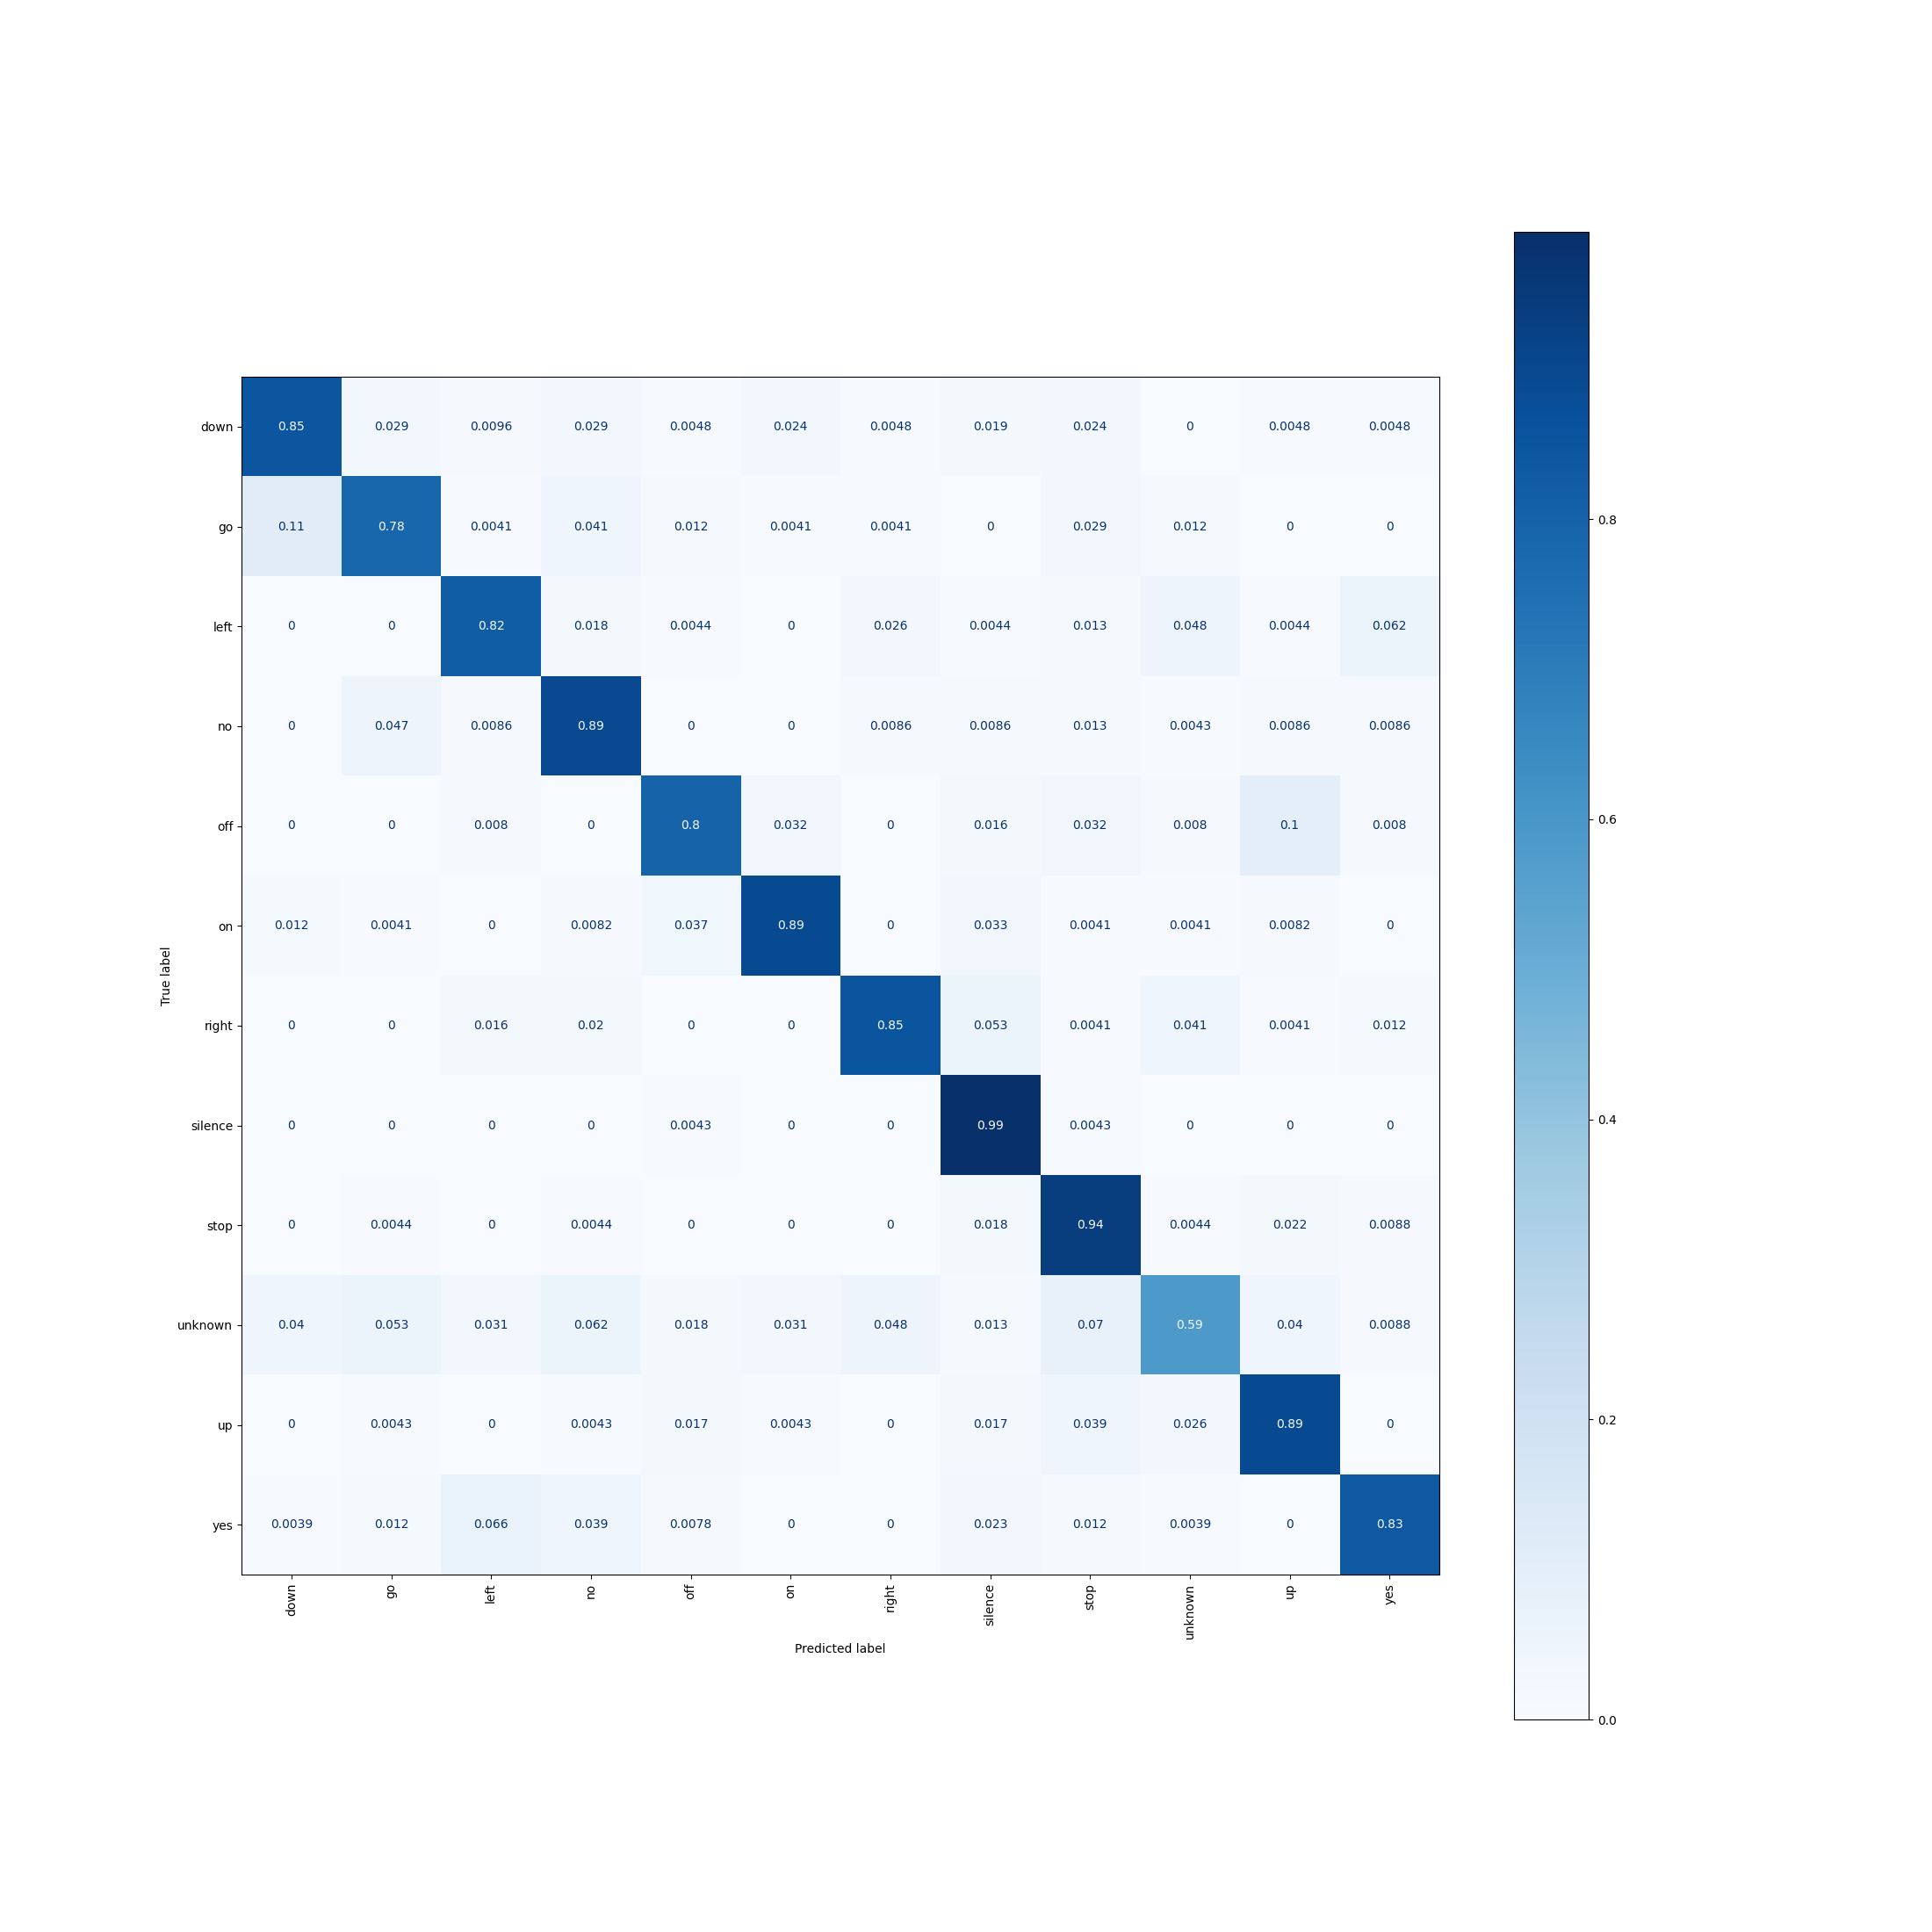 |

While the network trained well and had a fairly high validation
accuracy, I noticed that the accuracy for the class 'unknown' was much
lesser than the other classes. This was understandable, as this class
needed to be chosen for a large variety of spoken words. Thus, to boost
its accuracy I doubled the number of samples of the 'unknown' class.
After training on this modified data, the model performed much better on
the 'unknown class.'

The next step was to test the model on the provided test data and upload
to Kaggle.

In [ ]:
SAVE_PATH = "models/"
LOAD_MODEL_NAME = 'm5_more-unk'
BASE_DIR = 'train/audio'
TEST_DIR = 'test/audio'
BATCH_SIZE = 32

data_module = AudioCommandsModule(BASE_DIR, BATCH_SIZE)
model = AudioCommandsNN(1, 12, data_module.labels)

model.load_state_dict(torch.load(os.path.join(SAVE_PATH, LOAD_MODEL_NAME),
                                    map_location=torch.device('cuda')))
model.eval()
files = os.listdir(TEST_DIR)
csv = open('submission.csv','w')
csv.write('fname,label\n')
transform = torchvision.transforms.Compose([
    torchaudio.transforms.Resample(16000, 8000),
    torchvision.transforms.Lambda(lambda audio: torch.mul(audio, 10))
])
for idx, f in enumerate(files):
    audio = torchaudio.load(os.path.join(TEST_DIR, f))[0]
    padding = 16000 - audio.shape[1]
    audio = F.pad(audio, (floor(padding/2), ceil(padding/2)))
    audio = transform(audio)
    audio = torch.unsqueeze(audio, dim=0)
    output = model(audio)
    pred = data_module.labels[torch.argmax(output, axis=1)]
    print('%s/%s %s,%s' %(idx, len(files), f, pred), end='\r')
    csv.write('%s,%s\n' %(f, pred))
csv.close()



On submitting the csv file to Kaggle, the accuracy returned was just
9.8%, which was unexpectedly low. I investigated and found two things:

1.  On checking a few of the files in the test dataset manually, I found
    that some files contained no sound at all, instead of the background
    noise I was expecting for the 'silence' class. To rectify this, I
    included samples of no sound as well for the 'silence' class.
2.  More importantly, an very large number of the predictions was for
    the 'unknown' class. This seemed to indicate that the network was
    being overly cautious in making predictions, rarely making a
    prediction unless it was absolutely sure. I realized that this
    problem was exacerbated by the large number of 'unknown' samples I
    had included while training, and cut it down to a quarter of the
    number.

With these changes I tested again and the result was much more
encouraging, with 68% accuracy.

Finally, in order to test out the effect of my transforms, I tested the
model without using the resampling and scaling transforms. To my
surprise, the performance was even better, reaching 76.8%.

Network naming convention:

-   *m5* - Base architecture
-   *less-unk-sil* - Lesser amount of data used for the 'unknown' and
    'silence' class
-   *notrans* - No Resampling and Scaling transformations

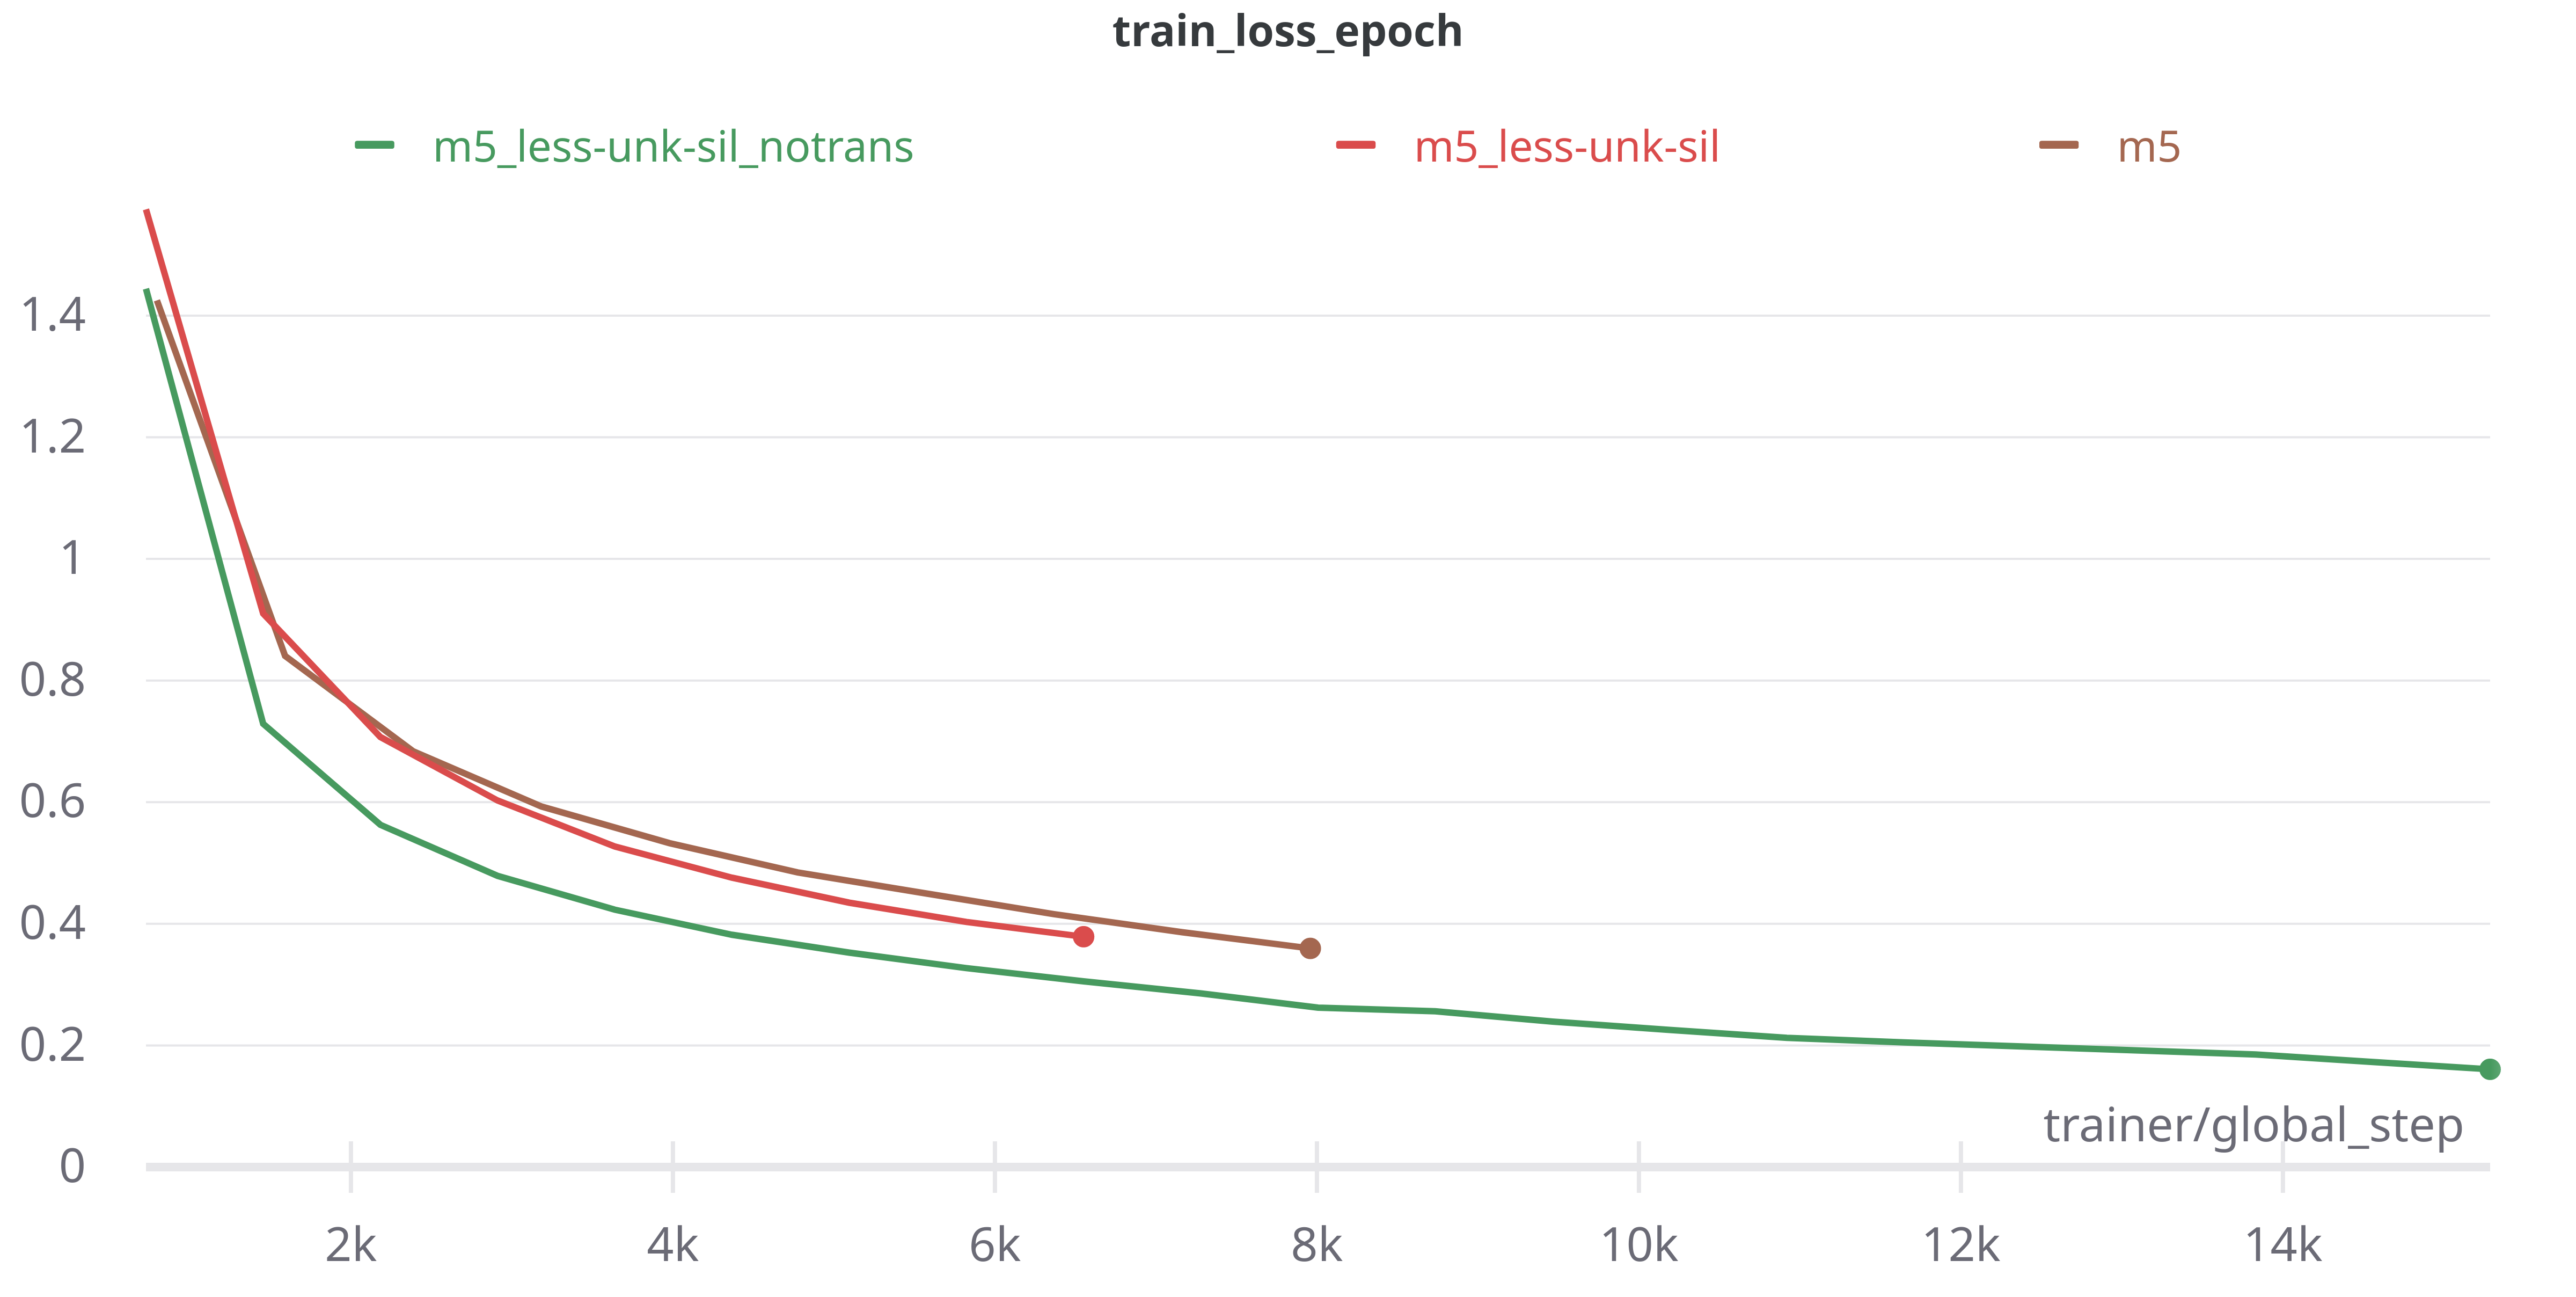

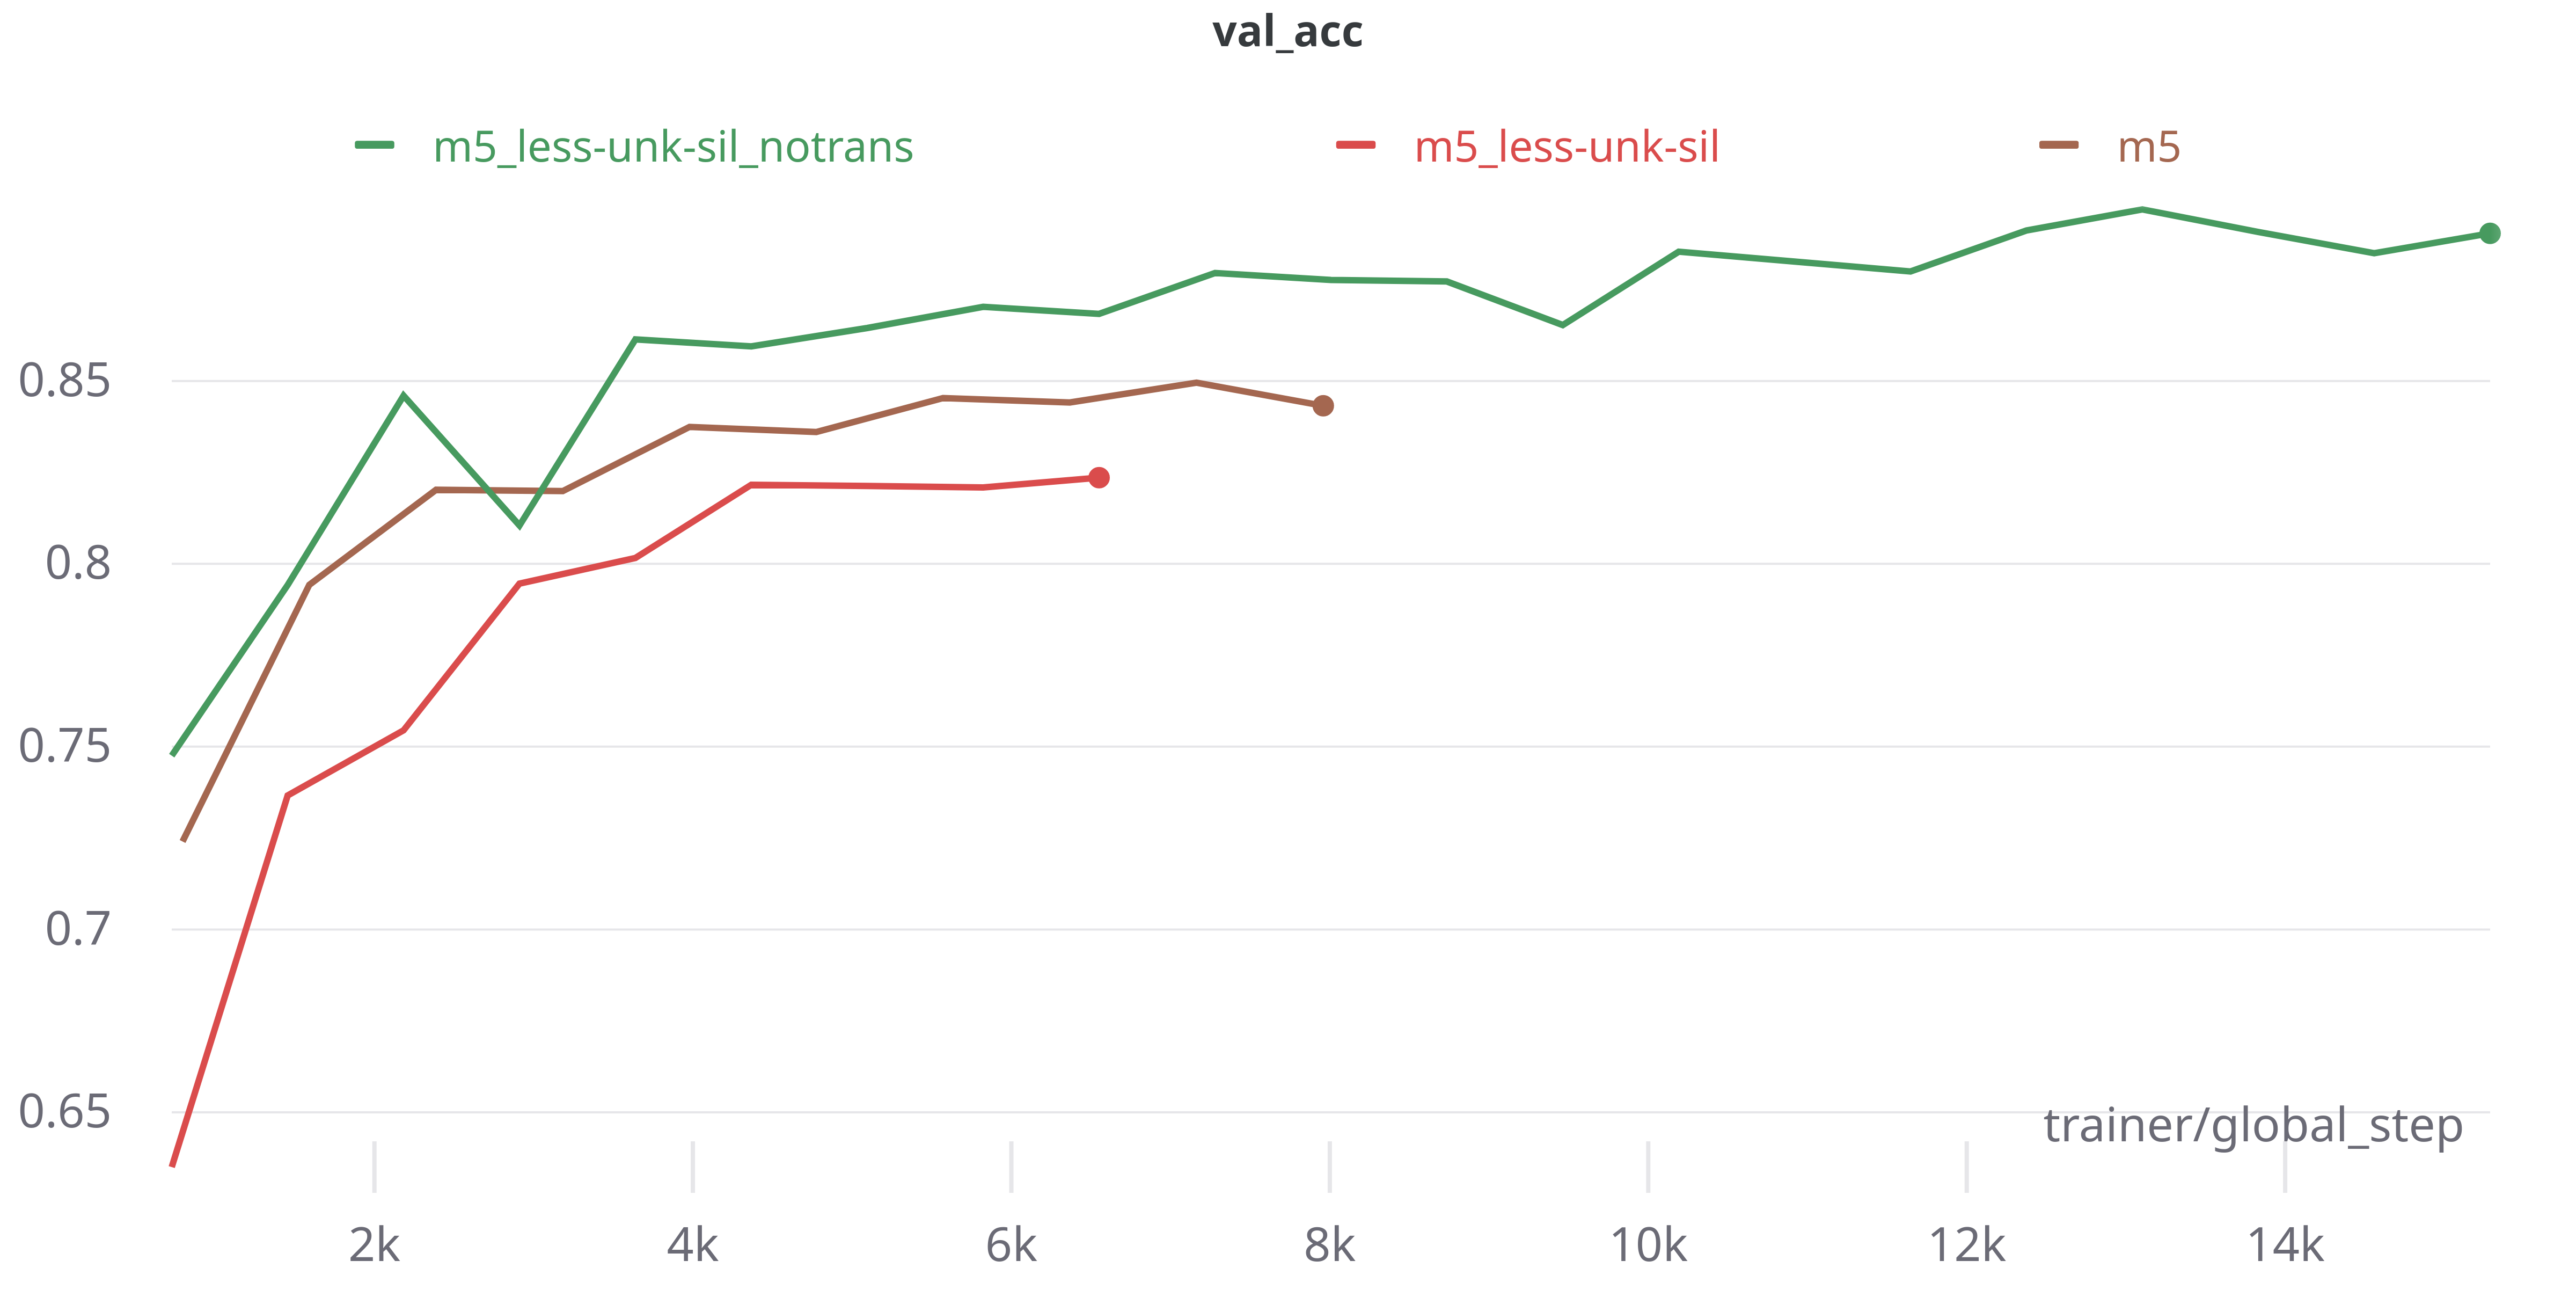

Confusion Matrix for *m5<sub>less</sub>-unk-sil<sub>notrans</sub>*

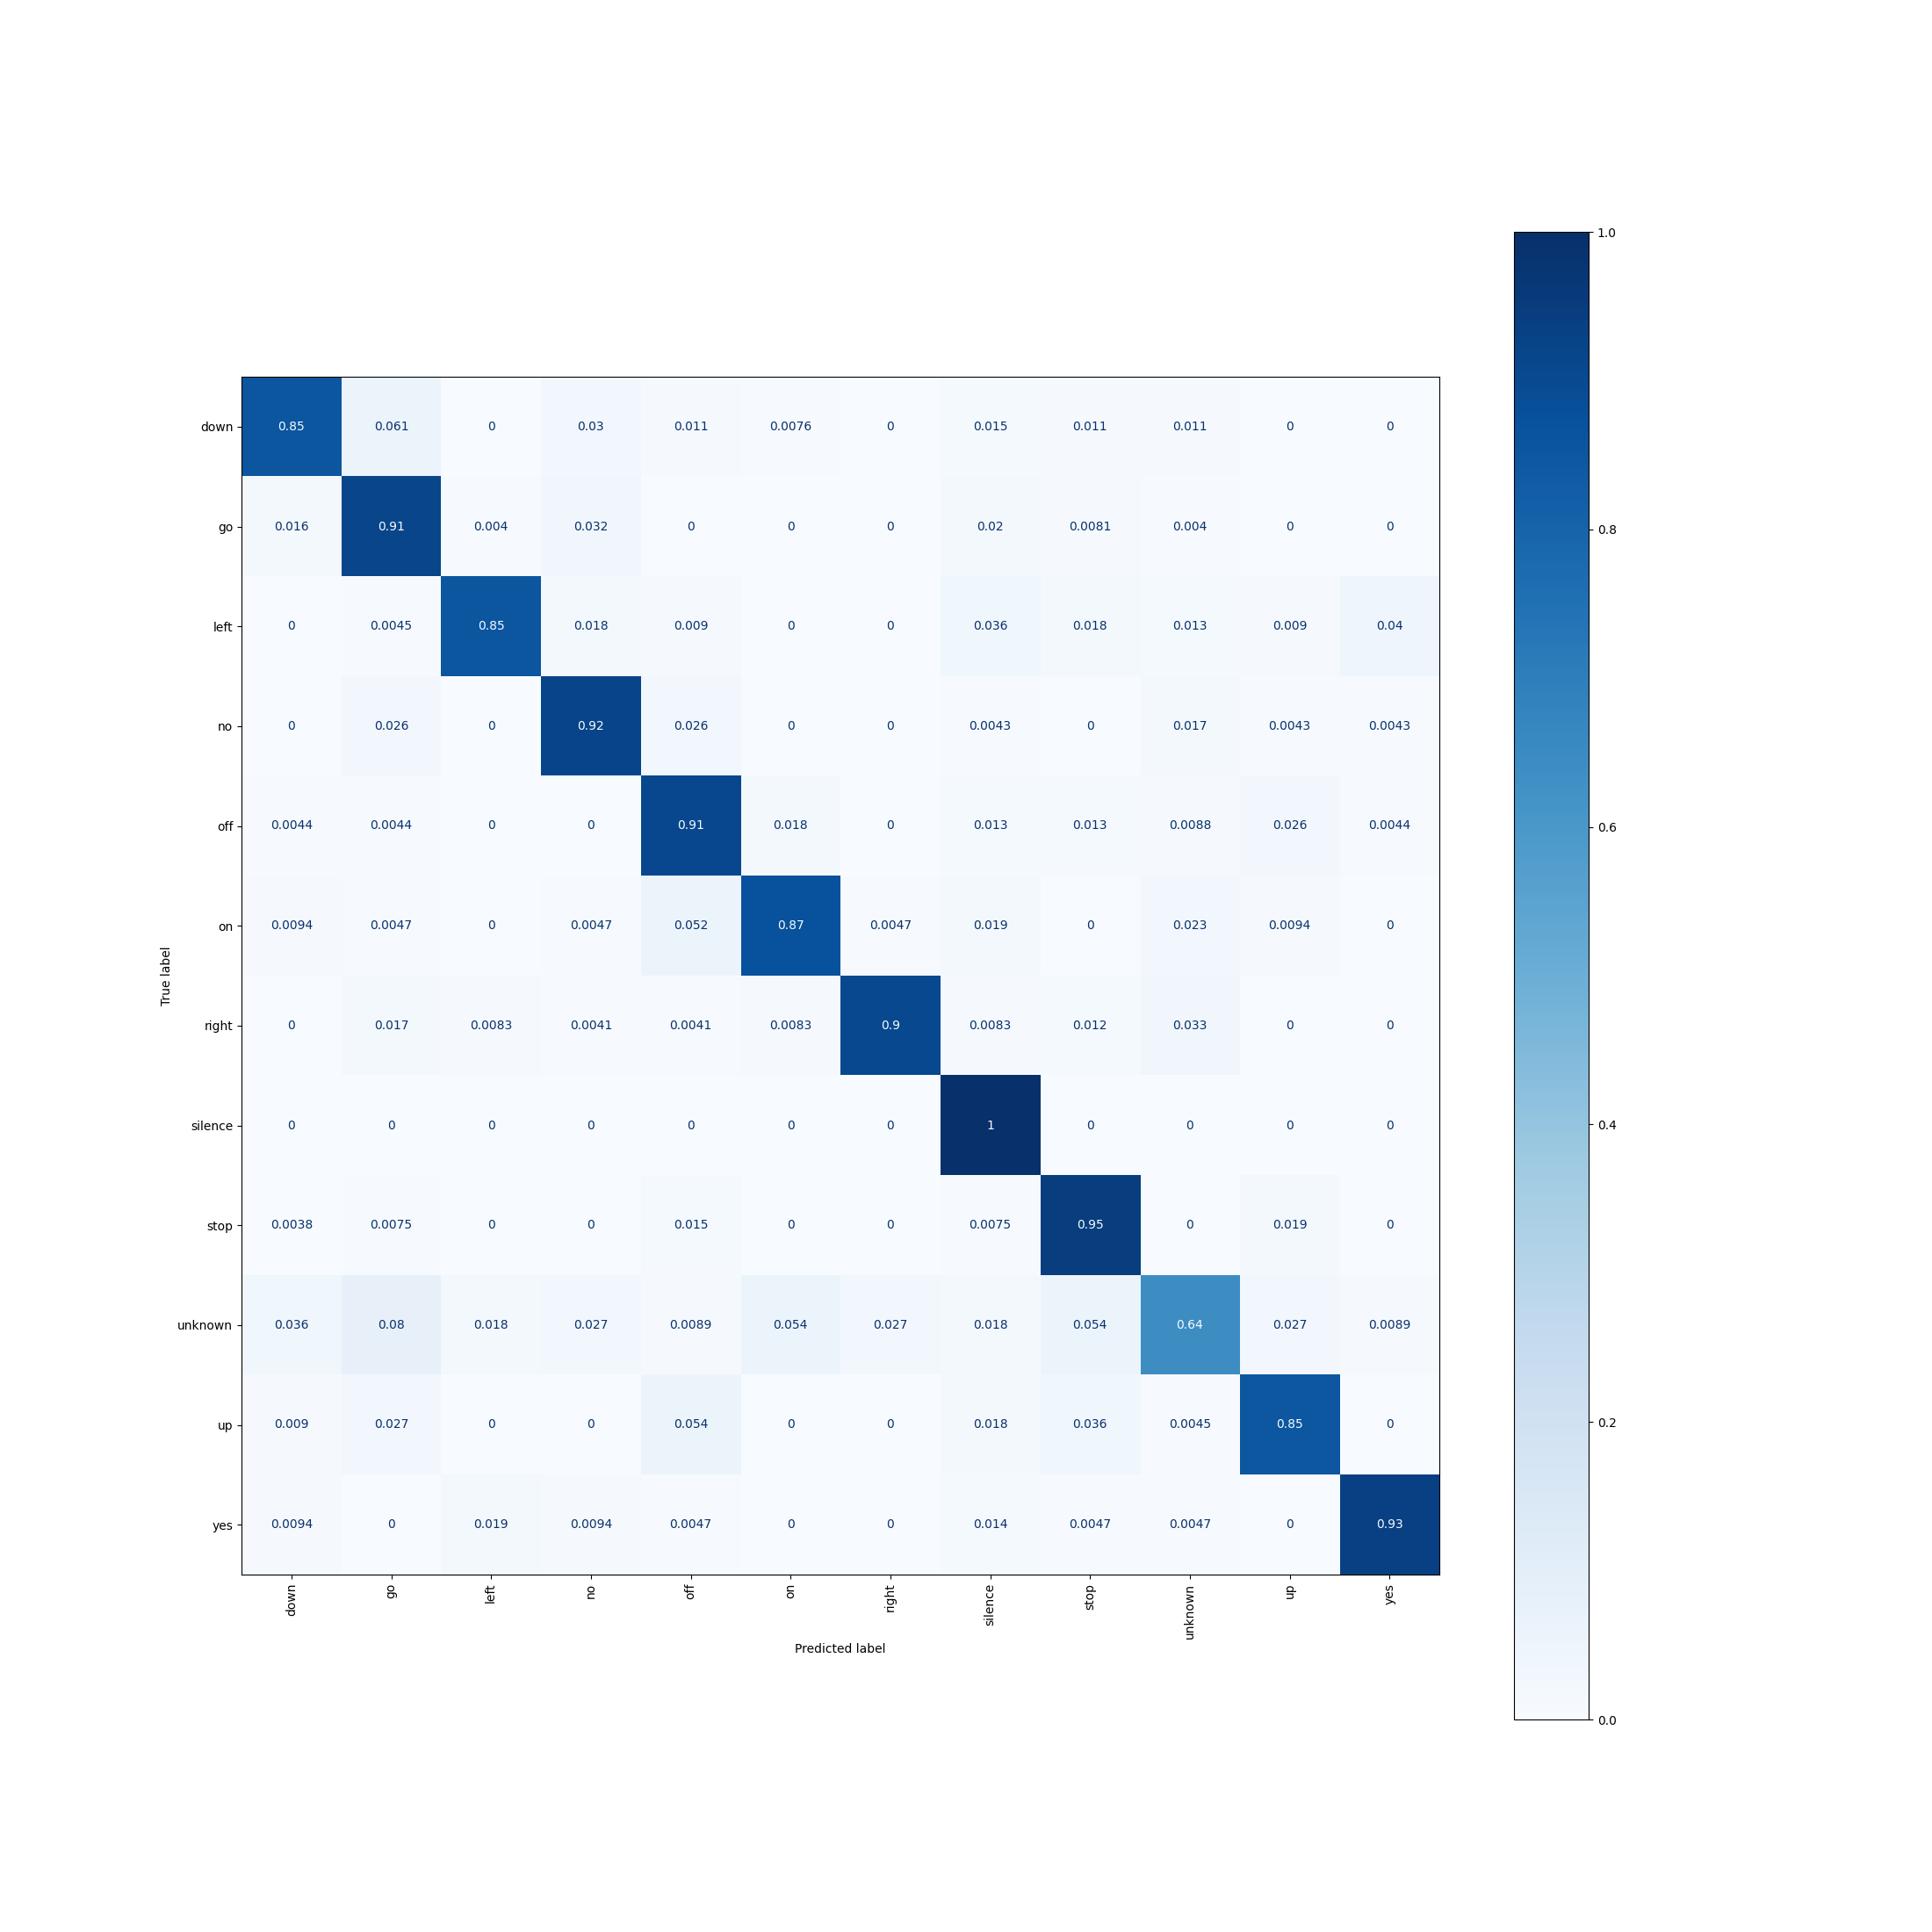

****Future Improvements****

-   The M5 architecture could be modified further, to incorporate more
    layers, or better techniques like the One Cycle Learning Rate
    Policy. [1]
-   Rather than using raw waveforms, the audio data can be processed
    into other possibly more useful features like MFCC used in [2].
-   Finally, for a Kaggle specific approach where the test results are
    hidden, one possible approach is manually tagging several hundred
    files with the correct class and plotting a confusion matrix with
    the neural network's output. This would help give us more insight
    into the predictions and which classes are proving troublesome.

[1] [Finding Good Learning Rate and The One Cycle
Policy.](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6)

[2] [Building an end-to-end Speech Recognition model in
PyTorch](https://www.assemblyai.com/blog/end-to-end-speech-recognition-pytorch)